# 2025美赛C题：建模分析流程

## 1. 问题分析与建模思路

### 📌 本Notebook的目标

本文档是2025年美国大学生数学建模竞赛（MCM）C题《奥运奖牌榜模型》的**建模分析流程**。我们将基于预处理后的数据，构建预测模型并分析东道主效应。

**核心任务（第一问）**：
- 预测各国在未来奥运会（2028洛杉矶）的奖牌数
- 分析影响奖牌数的关键因素
- 量化"东道主效应"

### 🎯 建模方法选择依据

| 分析维度 | 数据特征 | 推荐方法 |
|----------|----------|----------|
| **预测目标** | 连续数值（奖牌数） | 回归分析 |
| **自变量** | 多个特征（历史成绩、东道主等） | 多元回归 / 机器学习 |
| **时间维度** | 4年周期性 | 时间序列辅助 |
| **因果分析** | 东道主效应 | 相关性分析 / 假设检验 |

### 📊 分析路线图

```
数据加载 → 探索性分析 → 相关性分析（东道主效应）
                ↓
        回归模型构建
        ├── 线性回归（基线）
        ├── 岭回归/Lasso（正则化）
        ├── 随机森林（集成学习）
        └── XGBoost（梯度提升）
                ↓
        模型评估与比较 → 2028预测
```

---

> **💡 学习重点**：本教程不仅教你"怎么做"，更重要的是理解"为什么这样做"。每个模型选择都有其业务逻辑和数学原理。


In [2]:
# 导入必要的库
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

# 设置中文显示
plt.rcParams['font.sans-serif'] = ['Arial Unicode MS', 'SimHei', 'DejaVu Sans']
plt.rcParams['axes.unicode_minus'] = False

# 设置显示选项
pd.set_option('display.max_columns', 20)
pd.set_option('display.width', 200)
pd.set_option('display.float_format', '{:.3f}'.format)

print("✅ 基础库导入成功！")


✅ 基础库导入成功！


In [3]:
# 导入机器学习库
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from scipy import stats

print("✅ 机器学习库导入成功！")


✅ 机器学习库导入成功！


---

## 2. 数据加载与探索性分析

### 2.1 加载预处理后的数据

我们使用数据预处理阶段生成的 `processed_medal_data.csv`，该数据已完成：
- 缺失值处理
- 东道主标志添加
- 滞后特征（lag1, lag2）
- 滚动平均特征
- 其他衍生特征


In [4]:
# 加载预处理后的数据
df = pd.read_csv('../processed_medal_data.csv')

print("=" * 60)
print("📊 数据加载成功")
print("=" * 60)
print(f"\n数据形状: {df.shape}")
print(f"时间范围: {df['Year'].min()} - {df['Year'].max()}")
print(f"国家数量: {df['NOC'].nunique()}")

print("\n📋 数据列信息:")
for col in df.columns:
    print(f"  - {col}: {df[col].dtype}")

df.head()


📊 数据加载成功

数据形状: (1435, 16)
时间范围: 1896 - 2024
国家数量: 164

📋 数据列信息:
  - Rank: int64
  - NOC: object
  - Gold: int64
  - Silver: int64
  - Bronze: int64
  - Total: int64
  - Year: int64
  - is_host: int64
  - total_events: int64
  - total_lag1: float64
  - gold_lag1: float64
  - total_lag2: float64
  - total_rolling3_mean: float64
  - total_change: float64
  - participation_count: int64
  - gold_ratio: float64


,Rank,NOC,Gold,Silver,Bronze,Total,Year,is_host,total_events,total_lag1,gold_lag1,total_lag2,total_rolling3_mean,total_change,participation_count,gold_ratio
0,82,Afghanistan,0,0,1,1,2008,0,302,0.000,0.000,0.000,0.000,1.000,1,0.000
1,79,Afghanistan,0,0,1,1,2012,0,302,1.000,0.000,0.000,1.000,0.000,2,0.000
2,80,Albania,0,0,2,2,2024,0,329,0.000,0.000,0.000,0.000,2.000,1,0.000
3,42,Algeria,0,0,2,2,1984,0,221,0.000,0.000,0.000,0.000,2.000,1,0.000
4,34,Algeria,1,0,1,2,1992,0,257,2.000,0.000,0.000,2.000,0.000,2,0.500


### 2.2 目标变量分析

在建模之前，了解目标变量（Total奖牌数）的分布特征非常重要：
- **右偏分布**：大多数国家奖牌数较少，少数强国奖牌数很多
- **零膨胀**：部分国家某些届次可能零奖牌（但已被过滤）
- **异常值**：如美国、苏联等超级强国的奖牌数远高于平均值


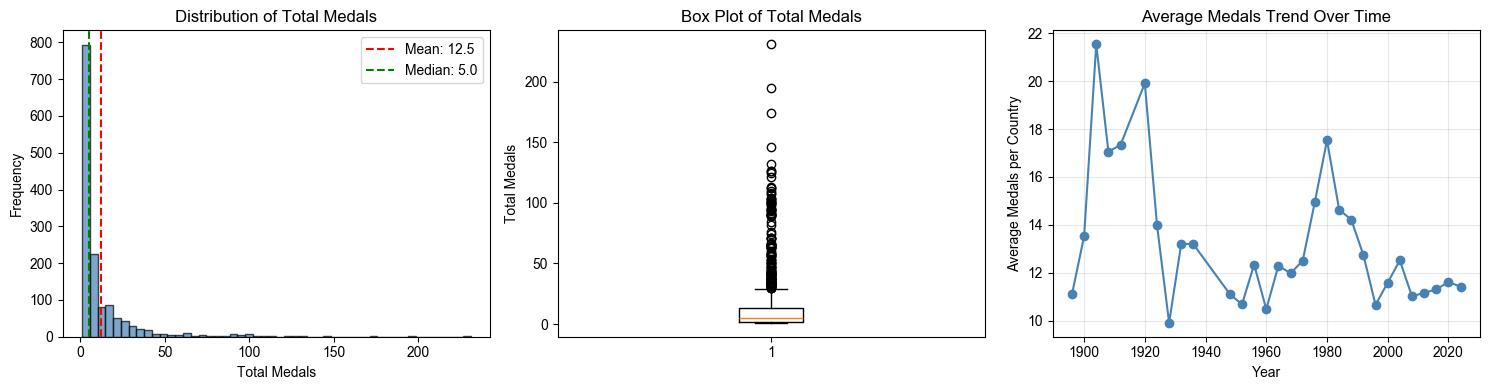

📊 目标变量统计摘要
count   1435.000
mean      12.459
std       21.583
min        1.000
25%        2.000
50%        5.000
75%       13.000
max      231.000
Name: Total, dtype: float64


In [5]:
# 目标变量（Total）的分布分析
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

# 1. 直方图
axes[0].hist(df['Total'], bins=50, edgecolor='black', alpha=0.7, color='steelblue')
axes[0].set_xlabel('Total Medals')
axes[0].set_ylabel('Frequency')
axes[0].set_title('Distribution of Total Medals')
axes[0].axvline(df['Total'].mean(), color='red', linestyle='--', label=f"Mean: {df['Total'].mean():.1f}")
axes[0].axvline(df['Total'].median(), color='green', linestyle='--', label=f"Median: {df['Total'].median():.1f}")
axes[0].legend()

# 2. 箱线图
axes[1].boxplot(df['Total'], vert=True)
axes[1].set_ylabel('Total Medals')
axes[1].set_title('Box Plot of Total Medals')

# 3. 按年份的趋势
yearly_stats = df.groupby('Year')['Total'].agg(['mean', 'sum', 'count'])
axes[2].plot(yearly_stats.index, yearly_stats['mean'], marker='o', color='steelblue')
axes[2].set_xlabel('Year')
axes[2].set_ylabel('Average Medals per Country')
axes[2].set_title('Average Medals Trend Over Time')
axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# 统计摘要
print("=" * 60)
print("📊 目标变量统计摘要")
print("=" * 60)
print(df['Total'].describe())


---

## 3. 相关性分析与东道主效应

### 3.1 特征相关性矩阵

相关性分析帮助我们理解：
1. 哪些特征与目标变量（Total）强相关 → 重要预测因子
2. 特征之间是否存在多重共线性 → 可能需要正则化
3. 东道主效应的量化 → is_host与Total的相关性


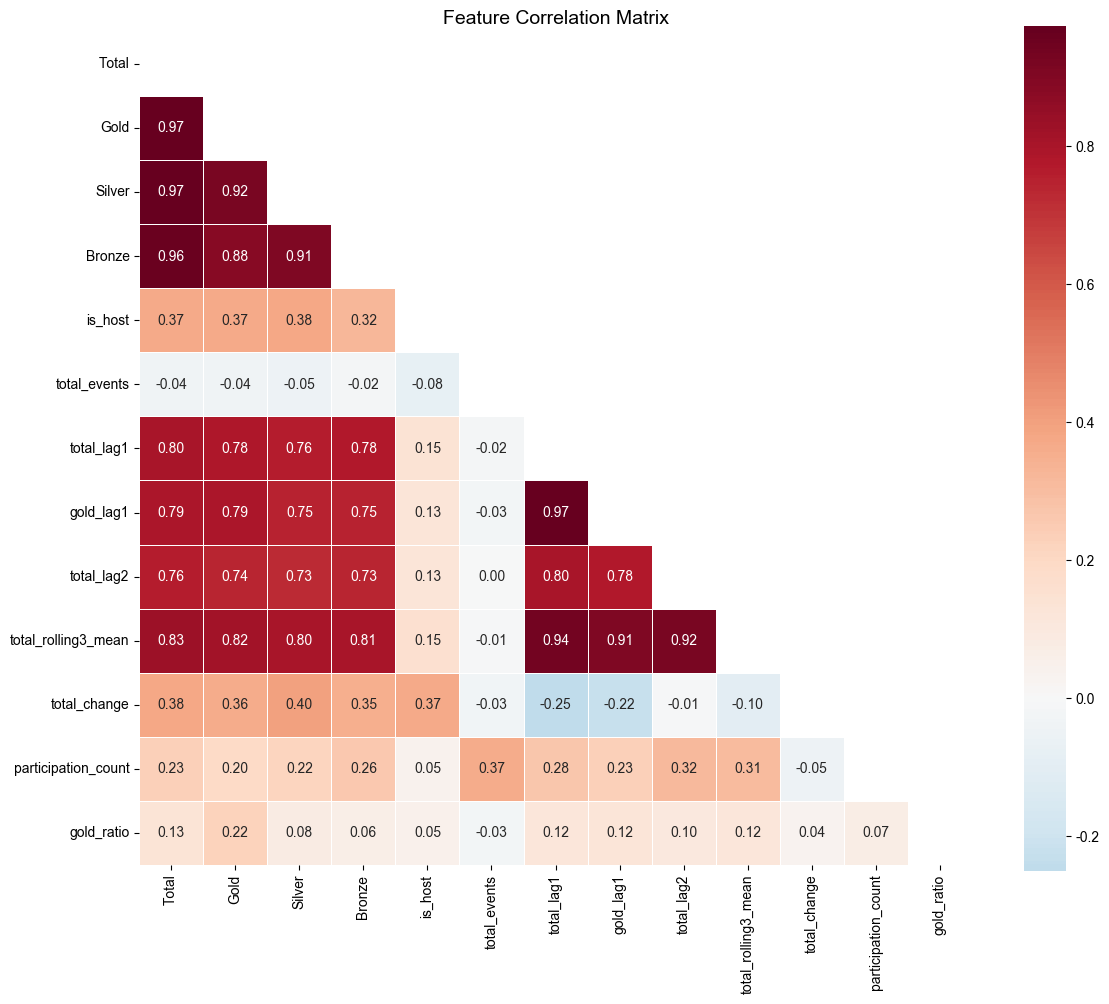

📊 各特征与Total的相关性（降序）
Total                  1.000
Silver                 0.974
Gold                   0.970
Bronze                 0.957
total_rolling3_mean    0.835
total_lag1             0.800
gold_lag1              0.791
total_lag2             0.759
total_change           0.381
is_host                0.368
participation_count    0.232
gold_ratio             0.134
total_events          -0.037
Name: Total, dtype: float64


In [6]:
# 选择数值型特征进行相关性分析
numeric_features = ['Total', 'Gold', 'Silver', 'Bronze', 'is_host', 'total_events',
                    'total_lag1', 'gold_lag1', 'total_lag2', 'total_rolling3_mean',
                    'total_change', 'participation_count', 'gold_ratio']

# 计算相关性矩阵
corr_matrix = df[numeric_features].corr()

# 绘制热力图
plt.figure(figsize=(12, 10))
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))  # 只显示下三角
sns.heatmap(corr_matrix, mask=mask, annot=True, fmt='.2f', cmap='RdBu_r',
            center=0, square=True, linewidths=0.5)
plt.title('Feature Correlation Matrix', fontsize=14)
plt.tight_layout()
plt.show()

# 与目标变量的相关性排序
print("=" * 60)
print("📊 各特征与Total的相关性（降序）")
print("=" * 60)
correlation_with_target = corr_matrix['Total'].sort_values(ascending=False)
print(correlation_with_target)


### 3.2 东道主效应深度分析

#### 什么是东道主效应？

研究表明，主办国在奥运会上通常会获得比平时更多的奖牌。这被称为"东道主效应"（Home Advantage）。

**可能的原因**：
1. 🏠 主场观众支持，运动员士气更高
2. ✈️ 无需长途旅行，身体状态更佳
3. 💰 主办国通常会增加体育投入
4. 🎯 裁判可能存在无意识的倾向性（主观评分项目）
5. 🏟️ 对场地更熟悉

#### 分析方法

我们使用以下方法量化东道主效应：
1. **描述性统计**：比较东道主与非东道主的平均奖牌数
2. **假设检验**：t检验验证差异是否显著
3. **效应量**：计算Cohen's d衡量效应大小


In [7]:
# 东道主效应分析
print("=" * 60)
print("🏠 东道主效应分析")
print("=" * 60)

# 分组统计
host_stats = df.groupby('is_host')['Total'].agg(['count', 'mean', 'std', 'median'])
host_stats.index = ['Non-Host', 'Host']
print("\n📊 基本统计:")
print(host_stats)

# 分离东道主和非东道主数据
host_medals = df[df['is_host'] == 1]['Total']
non_host_medals = df[df['is_host'] == 0]['Total']

# t检验
t_stat, p_value = stats.ttest_ind(host_medals, non_host_medals)
print(f"\n📈 独立样本t检验:")
print(f"  t统计量: {t_stat:.4f}")
print(f"  p值: {p_value:.6f}")
print(f"  结论: {'差异显著 (p < 0.05)' if p_value < 0.05 else '差异不显著'}")

# Cohen's d 效应量
def cohens_d(group1, group2):
    n1, n2 = len(group1), len(group2)
    var1, var2 = group1.var(), group2.var()
    pooled_std = np.sqrt(((n1-1)*var1 + (n2-1)*var2) / (n1+n2-2))
    return (group1.mean() - group2.mean()) / pooled_std

d = cohens_d(host_medals, non_host_medals)
print(f"\n📏 效应量 (Cohen's d): {d:.4f}")
print(f"  解释: ", end="")
if abs(d) < 0.2:
    print("微小效应")
elif abs(d) < 0.5:
    print("小效应")
elif abs(d) < 0.8:
    print("中等效应")
else:
    print("大效应")

# 计算东道主效应的增幅
increase_pct = (host_medals.mean() - non_host_medals.mean()) / non_host_medals.mean() * 100
print(f"\n🎯 东道主平均奖牌增幅: {increase_pct:.1f}%")


🏠 东道主效应分析

📊 基本统计:
          count   mean    std  median
Non-Host   1405 11.297 18.535   4.000
Host         30 66.867 57.207  43.500

📈 独立样本t检验:
  t统计量: 15.0054
  p值: 0.000000
  结论: 差异显著 (p < 0.05)

📏 效应量 (Cohen's d): 2.7687
  解释: 大效应

🎯 东道主平均奖牌增幅: 491.9%


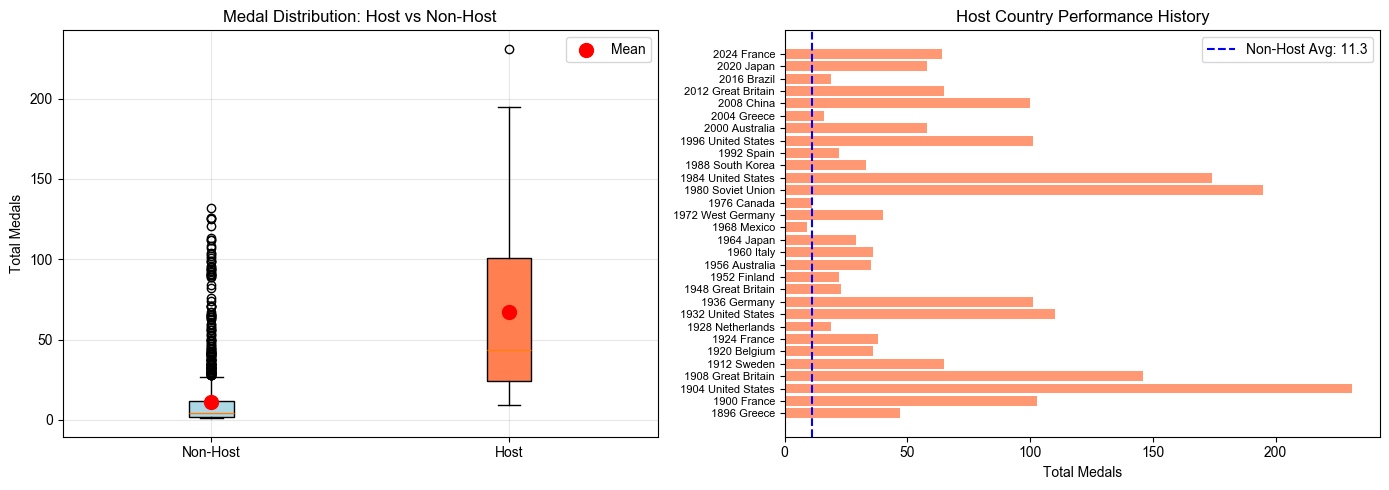

In [8]:
# 可视化东道主效应
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# 1. 箱线图比较
bp = axes[0].boxplot([non_host_medals, host_medals], labels=['Non-Host', 'Host'], 
                      patch_artist=True)
bp['boxes'][0].set_facecolor('lightblue')
bp['boxes'][1].set_facecolor('coral')
axes[0].set_ylabel('Total Medals')
axes[0].set_title('Medal Distribution: Host vs Non-Host')
axes[0].grid(True, alpha=0.3)

# 添加均值标记
axes[0].scatter([1, 2], [non_host_medals.mean(), host_medals.mean()], 
                color='red', s=100, zorder=5, label='Mean')
axes[0].legend()

# 2. 东道主历史表现
host_records = df[df['is_host'] == 1][['Year', 'NOC', 'Total']].sort_values('Year')
axes[1].barh(range(len(host_records)), host_records['Total'], color='coral', alpha=0.8)
axes[1].set_yticks(range(len(host_records)))
axes[1].set_yticklabels([f"{row['Year']} {row['NOC']}" for _, row in host_records.iterrows()], fontsize=8)
axes[1].set_xlabel('Total Medals')
axes[1].set_title('Host Country Performance History')
axes[1].axvline(non_host_medals.mean(), color='blue', linestyle='--', 
                label=f'Non-Host Avg: {non_host_medals.mean():.1f}')
axes[1].legend()

plt.tight_layout()
plt.show()


---

## 4. 回归模型构建

### 4.1 数据准备

在训练模型之前，我们需要：
1. **选择特征**：排除目标变量本身及其衍生变量（避免数据泄露）
2. **划分数据集**：训练集（历史数据）和测试集（最近几届）
3. **特征标准化**：某些模型（如线性回归）对特征尺度敏感

#### 特征选择原则

| 类型 | 可用特征 | 不可用特征 |
|------|----------|------------|
| 历史特征 | total_lag1, total_lag2, gold_lag1 | Total, Gold, Silver, Bronze（目标） |
| 滚动特征 | total_rolling3_mean | total_change（包含当前值） |
| 类别特征 | is_host, participation_count | NOC（需编码） |
| 环境特征 | total_events | gold_ratio（包含当前值） |


In [9]:
# 定义特征和目标变量
# 这些是"预测时刻已知"的特征，不会造成数据泄露
feature_columns = [
    'total_lag1',           # 上一届奖牌数
    'total_lag2',           # 上两届奖牌数
    'gold_lag1',            # 上一届金牌数
    'total_rolling3_mean',  # 过去3届平均
    'is_host',              # 是否为东道主
    'total_events',         # 当届总项目数
    'participation_count',  # 参赛届数
]

target_column = 'Total'

# 准备特征矩阵和目标向量
X = df[feature_columns].copy()
y = df[target_column].copy()

print("=" * 60)
print("📊 特征与目标变量准备完成")
print("=" * 60)
print(f"\n特征矩阵形状: {X.shape}")
print(f"目标向量形状: {y.shape}")
print(f"\n选用特征: {feature_columns}")


📊 特征与目标变量准备完成

特征矩阵形状: (1435, 7)
目标向量形状: (1435,)

选用特征: ['total_lag1', 'total_lag2', 'gold_lag1', 'total_rolling3_mean', 'is_host', 'total_events', 'participation_count']


In [10]:
# 划分训练集和测试集
# 对于时间序列数据，使用"时间划分"而非随机划分更合理
# 训练集：2020年及之前的数据
# 测试集：2024年的数据（用于验证）

train_mask = df['Year'] <= 2020
test_mask = df['Year'] == 2024

X_train = X[train_mask]
X_test = X[test_mask]
y_train = y[train_mask]
y_test = y[test_mask]

print("=" * 60)
print("📊 数据集划分完成（时间序列划分）")
print("=" * 60)
print(f"\n训练集: {X_train.shape[0]} 条 (≤2020年)")
print(f"测试集: {X_test.shape[0]} 条 (2024年)")

# 同时准备一个随机划分的版本（用于交叉验证）
X_train_rand, X_test_rand, y_train_rand, y_test_rand = train_test_split(
    X, y, test_size=0.2, random_state=42
)
print(f"\n随机划分: 训练集 {X_train_rand.shape[0]} 条, 测试集 {X_test_rand.shape[0]} 条")


📊 数据集划分完成（时间序列划分）

训练集: 1344 条 (≤2020年)
测试集: 91 条 (2024年)

随机划分: 训练集 1148 条, 测试集 287 条


In [11]:
# 特征标准化
# 注意：只用训练集拟合scaler，避免数据泄露！
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# 为随机划分的数据也做标准化
scaler_rand = StandardScaler()
X_train_rand_scaled = scaler_rand.fit_transform(X_train_rand)
X_test_rand_scaled = scaler_rand.transform(X_test_rand)

print("✅ 特征标准化完成")
print("\n💡 注意：标准化时只用训练集fit，测试集只transform，避免数据泄露")


✅ 特征标准化完成

💡 注意：标准化时只用训练集fit，测试集只transform，避免数据泄露


### 4.2 线性回归（基线模型）

#### 为什么从线性回归开始？

1. **简单可解释**：系数直接反映特征对目标的影响方向和大小
2. **建立基线**：为后续复杂模型提供比较基准
3. **诊断数据**：残差分析可以发现数据问题

#### 模型形式

$$
\hat{y} = \beta_0 + \beta_1 x_1 + \beta_2 x_2 + ... + \beta_n x_n
$$

其中：
- $\hat{y}$：预测的奖牌数
- $\beta_0$：截距（基准值）
- $\beta_i$：第i个特征的系数（每增加1单位对应的奖牌变化）


In [12]:
# 训练线性回归模型
lr_model = LinearRegression()
lr_model.fit(X_train_scaled, y_train)

# 预测
y_pred_lr = lr_model.predict(X_test_scaled)

# 评估指标
def evaluate_model(y_true, y_pred, model_name):
    """计算并打印模型评估指标"""
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    
    print(f"\n📊 {model_name} 评估结果:")
    print(f"  - MSE (均方误差): {mse:.2f}")
    print(f"  - RMSE (均方根误差): {rmse:.2f}")
    print(f"  - MAE (平均绝对误差): {mae:.2f}")
    print(f"  - R² (决定系数): {r2:.4f}")
    
    return {'mse': mse, 'rmse': rmse, 'mae': mae, 'r2': r2}

print("=" * 60)
print("📈 线性回归模型")
print("=" * 60)

lr_metrics = evaluate_model(y_test, y_pred_lr, "Linear Regression")

# 查看系数
print("\n📋 特征系数（标准化后）:")
coef_df = pd.DataFrame({
    'Feature': feature_columns,
    'Coefficient': lr_model.coef_
}).sort_values('Coefficient', key=abs, ascending=False)
print(coef_df.to_string(index=False))

print(f"\n截距 (Intercept): {lr_model.intercept_:.2f}")


📈 线性回归模型

📊 Linear Regression 评估结果:
  - MSE (均方误差): 20.96
  - RMSE (均方根误差): 4.58
  - MAE (平均绝对误差): 3.00
  - R² (决定系数): 0.9454

📋 特征系数（标准化后）:
            Feature  Coefficient
total_rolling3_mean       13.541
          gold_lag1        6.213
            is_host        5.522
         total_lag1       -2.718
         total_lag2        0.649
participation_count       -0.502
       total_events        0.140

截距 (Intercept): 12.53


### 4.3 正则化回归（Ridge & Lasso）

#### 为什么需要正则化？

当特征之间存在**多重共线性**（如total_lag1和total_rolling3_mean高度相关）时，普通线性回归的系数可能不稳定。正则化通过添加惩罚项来：

1. **Ridge (L2正则化)**：缩小系数，但不会使系数变为0
   - $\text{Loss} = \text{MSE} + \alpha \sum \beta_i^2$
   - 适合所有特征都有用的情况

2. **Lasso (L1正则化)**：可以使某些系数变为0，实现特征选择
   - $\text{Loss} = \text{MSE} + \alpha \sum |\beta_i|$
   - 适合有冗余特征需要筛选的情况


In [13]:
# Ridge回归
print("=" * 60)
print("📈 Ridge回归 (L2正则化)")
print("=" * 60)

ridge_model = Ridge(alpha=1.0)  # alpha是正则化强度
ridge_model.fit(X_train_scaled, y_train)
y_pred_ridge = ridge_model.predict(X_test_scaled)
ridge_metrics = evaluate_model(y_test, y_pred_ridge, "Ridge Regression")

# Lasso回归
print("\n" + "=" * 60)
print("📈 Lasso回归 (L1正则化)")
print("=" * 60)

lasso_model = Lasso(alpha=0.1)  # Lasso通常需要较小的alpha
lasso_model.fit(X_train_scaled, y_train)
y_pred_lasso = lasso_model.predict(X_test_scaled)
lasso_metrics = evaluate_model(y_test, y_pred_lasso, "Lasso Regression")

# 比较系数
print("\n📋 三种线性模型系数对比:")
coef_comparison = pd.DataFrame({
    'Feature': feature_columns,
    'Linear': lr_model.coef_,
    'Ridge': ridge_model.coef_,
    'Lasso': lasso_model.coef_
})
print(coef_comparison.to_string(index=False))

print("\n💡 观察：Lasso使某些系数变为0，实现了特征选择")


📈 Ridge回归 (L2正则化)

📊 Ridge Regression 评估结果:
  - MSE (均方误差): 20.93
  - RMSE (均方根误差): 4.57
  - MAE (平均绝对误差): 3.00
  - R² (决定系数): 0.9455

📈 Lasso回归 (L1正则化)

📊 Lasso Regression 评估结果:
  - MSE (均方误差): 19.81
  - RMSE (均方根误差): 4.45
  - MAE (平均绝对误差): 2.88
  - R² (决定系数): 0.9484

📋 三种线性模型系数对比:
            Feature  Linear  Ridge  Lasso
         total_lag1  -2.718 -2.461 -0.000
         total_lag2   0.649  0.758  1.010
          gold_lag1   6.213  6.095  4.430
total_rolling3_mean  13.541 13.299 12.164
            is_host   5.522  5.519  5.410
       total_events   0.140  0.138  0.000
participation_count  -0.502 -0.503 -0.365

💡 观察：Lasso使某些系数变为0，实现了特征选择


### 4.4 随机森林回归

#### 为什么使用随机森林？

随机森林是一种**集成学习**方法，它的优势在于：

1. **非线性关系**：可以捕捉特征与目标之间的复杂非线性关系
2. **特征交互**：自动学习特征之间的交互效应
3. **鲁棒性**：对异常值和噪声不敏感
4. **特征重要性**：提供特征重要性排序

#### 工作原理

```
        数据 → 随机抽样 → 多棵决策树 → 投票/平均 → 最终预测
              ↓           ↓           ↓
           Bootstrap    各自独立     减少方差
           样本         生长        提高稳定性
```


🌲 随机森林回归

📊 Random Forest 评估结果:
  - MSE (均方误差): 27.01
  - RMSE (均方根误差): 5.20
  - MAE (平均绝对误差): 3.17
  - R² (决定系数): 0.9297

📊 特征重要性排序:
            Feature  Importance
          gold_lag1       0.345
         total_lag1       0.332
total_rolling3_mean       0.151
            is_host       0.065
       total_events       0.044
         total_lag2       0.040
participation_count       0.022


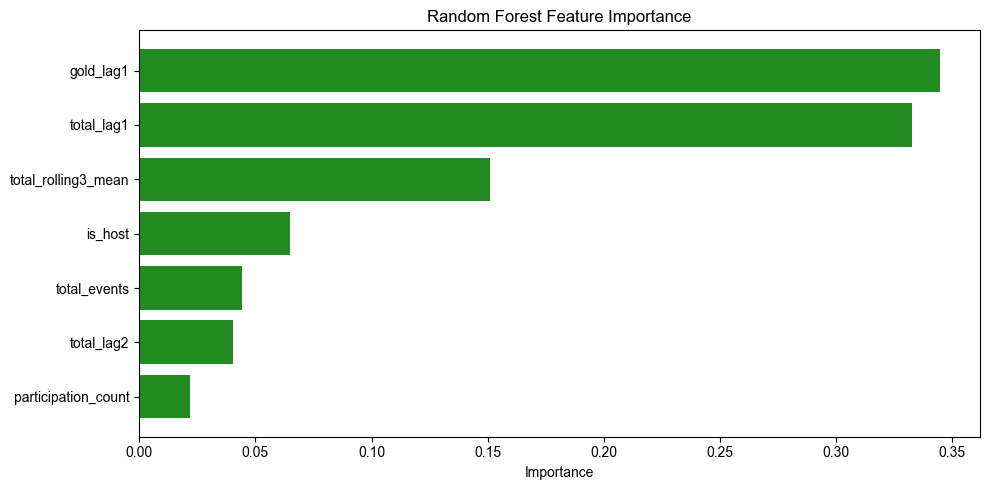

In [14]:
# 随机森林回归
# 注意：随机森林不需要特征标准化
print("=" * 60)
print("🌲 随机森林回归")
print("=" * 60)

rf_model = RandomForestRegressor(
    n_estimators=100,      # 树的数量
    max_depth=10,          # 最大深度，防止过拟合
    min_samples_split=5,   # 分裂所需最小样本数
    min_samples_leaf=2,    # 叶节点最小样本数
    random_state=42
)
rf_model.fit(X_train, y_train)  # 不需要标准化
y_pred_rf = rf_model.predict(X_test)
rf_metrics = evaluate_model(y_test, y_pred_rf, "Random Forest")

# 特征重要性
print("\n📊 特征重要性排序:")
importance_df = pd.DataFrame({
    'Feature': feature_columns,
    'Importance': rf_model.feature_importances_
}).sort_values('Importance', ascending=False)
print(importance_df.to_string(index=False))

# 可视化特征重要性
plt.figure(figsize=(10, 5))
plt.barh(importance_df['Feature'], importance_df['Importance'], color='forestgreen')
plt.xlabel('Importance')
plt.title('Random Forest Feature Importance')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()


### 4.5 梯度提升回归 (Gradient Boosting)

#### 为什么使用梯度提升？

梯度提升是另一种集成学习方法，与随机森林不同的是它采用**序列学习**：

| 对比项 | 随机森林 | 梯度提升 |
|--------|----------|----------|
| 训练方式 | 并行（独立训练多棵树） | 串行（每棵树学习前一棵的残差） |
| 目标 | 减少方差 | 减少偏差 |
| 速度 | 较快 | 较慢 |
| 精度 | 好 | 通常更好 |
| 过拟合风险 | 较低 | 较高（需要调参）|

#### 常用实现
- **GradientBoostingRegressor** (sklearn)
- **XGBoost** (极端梯度提升)
- **LightGBM** (轻量级梯度提升)


In [15]:
# 梯度提升回归
print("=" * 60)
print("🚀 梯度提升回归 (Gradient Boosting)")
print("=" * 60)

gb_model = GradientBoostingRegressor(
    n_estimators=100,      # 迭代次数
    learning_rate=0.1,     # 学习率，越小越稳定
    max_depth=5,           # 每棵树的最大深度
    min_samples_split=5,
    min_samples_leaf=2,
    random_state=42
)
gb_model.fit(X_train, y_train)
y_pred_gb = gb_model.predict(X_test)
gb_metrics = evaluate_model(y_test, y_pred_gb, "Gradient Boosting")

# 特征重要性
print("\n📊 特征重要性排序:")
gb_importance_df = pd.DataFrame({
    'Feature': feature_columns,
    'Importance': gb_model.feature_importances_
}).sort_values('Importance', ascending=False)
print(gb_importance_df.to_string(index=False))


🚀 梯度提升回归 (Gradient Boosting)

📊 Gradient Boosting 评估结果:
  - MSE (均方误差): 21.16
  - RMSE (均方根误差): 4.60
  - MAE (平均绝对误差): 2.97
  - R² (决定系数): 0.9449

📊 特征重要性排序:
            Feature  Importance
          gold_lag1       0.392
         total_lag1       0.283
total_rolling3_mean       0.153
            is_host       0.064
       total_events       0.055
         total_lag2       0.030
participation_count       0.023


---

## 5. 模型评估与比较

### 5.1 模型性能汇总

我们使用以下指标评估模型：
- **RMSE (均方根误差)**：对大误差敏感，单位与原数据相同
- **MAE (平均绝对误差)**：更直观，对异常值不敏感
- **R² (决定系数)**：解释方差的比例，1表示完美，0表示与均值预测一样


In [16]:
# 汇总所有模型的评估结果
print("=" * 60)
print("📊 模型性能对比")
print("=" * 60)

results = pd.DataFrame({
    'Model': ['Linear Regression', 'Ridge', 'Lasso', 'Random Forest', 'Gradient Boosting'],
    'RMSE': [lr_metrics['rmse'], ridge_metrics['rmse'], lasso_metrics['rmse'], 
             rf_metrics['rmse'], gb_metrics['rmse']],
    'MAE': [lr_metrics['mae'], ridge_metrics['mae'], lasso_metrics['mae'], 
            rf_metrics['mae'], gb_metrics['mae']],
    'R²': [lr_metrics['r2'], ridge_metrics['r2'], lasso_metrics['r2'], 
           rf_metrics['r2'], gb_metrics['r2']]
})

print(results.to_string(index=False))

# 找出最佳模型
best_model_idx = results['R²'].idxmax()
print(f"\n🏆 最佳模型: {results.loc[best_model_idx, 'Model']} (R² = {results.loc[best_model_idx, 'R²']:.4f})")


📊 模型性能对比
            Model  RMSE   MAE    R²
Linear Regression 4.578 3.002 0.945
            Ridge 4.575 3.001 0.945
            Lasso 4.451 2.880 0.948
    Random Forest 5.197 3.173 0.930
Gradient Boosting 4.600 2.973 0.945

🏆 最佳模型: Lasso (R² = 0.9484)


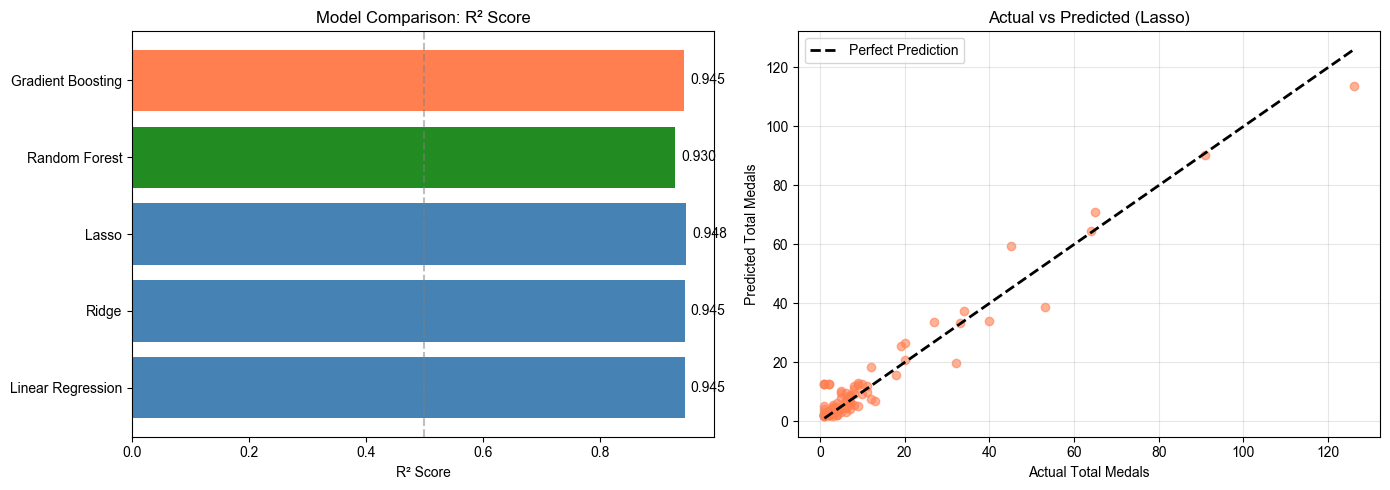

In [17]:
# 可视化对比
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# 1. 各模型R²对比
colors = ['steelblue', 'steelblue', 'steelblue', 'forestgreen', 'coral']
axes[0].barh(results['Model'], results['R²'], color=colors)
axes[0].set_xlabel('R² Score')
axes[0].set_title('Model Comparison: R² Score')
axes[0].axvline(0.5, color='gray', linestyle='--', alpha=0.5, label='R²=0.5 baseline')
for i, v in enumerate(results['R²']):
    axes[0].text(v + 0.01, i, f'{v:.3f}', va='center')

# 2. 预测值 vs 实际值 (使用最佳模型)
# 选择表现最好的模型进行详细展示
predictions = {
    'Linear Regression': y_pred_lr,
    'Ridge': y_pred_ridge,
    'Random Forest': y_pred_rf,
    'Gradient Boosting': y_pred_gb
}

best_model_name = results.loc[best_model_idx, 'Model']
if 'Linear' in best_model_name:
    best_pred = y_pred_lr
elif 'Ridge' in best_model_name:
    best_pred = y_pred_ridge
elif 'Random' in best_model_name:
    best_pred = y_pred_rf
else:
    best_pred = y_pred_gb

axes[1].scatter(y_test, best_pred, alpha=0.6, color='coral')
axes[1].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 
             'k--', lw=2, label='Perfect Prediction')
axes[1].set_xlabel('Actual Total Medals')
axes[1].set_ylabel('Predicted Total Medals')
axes[1].set_title(f'Actual vs Predicted ({best_model_name})')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


---

## 6. 2028年洛杉矶奥运会预测

### 6.1 准备预测数据

要预测2028年的奖牌数，我们需要为每个国家准备以下特征：
- `total_lag1`：2024年的奖牌数（已知）
- `total_lag2`：2020年的奖牌数（已知）
- `gold_lag1`：2024年的金牌数（已知）
- `total_rolling3_mean`：2020-2024的平均
- `is_host`：美国为1，其他为0
- `total_events`：使用2024年的值作为近似
- `participation_count`：+1

**重要**：2028年美国是东道主，这是一个关键特征！


In [18]:
# 构建2028年预测数据
print("=" * 60)
print("🔮 构建2028年预测数据")
print("=" * 60)

# 获取2024年的数据作为基础
df_2024 = df[df['Year'] == 2024].copy()

# 构建2028预测特征
df_2028 = df_2024[['NOC']].copy()

# 使用2024年数据作为lag1
df_2028['total_lag1'] = df_2024['Total'].values
df_2028['gold_lag1'] = df_2024['Gold'].values

# 使用2020年数据作为lag2
df_2020 = df[df['Year'] == 2020].set_index('NOC')['Total']
df_2028['total_lag2'] = df_2028['NOC'].map(df_2020).fillna(0)

# 计算rolling平均 (2016-2020-2024的平均)
def get_rolling_mean(noc):
    country_data = df[df['NOC'] == noc].sort_values('Year')
    recent_3 = country_data.tail(3)['Total'].mean()
    return recent_3

df_2028['total_rolling3_mean'] = df_2028['NOC'].apply(get_rolling_mean)

# 东道主标志 - 美国是2028年东道主
df_2028['is_host'] = (df_2028['NOC'] == 'United States').astype(int)

# 使用2024年的总项目数作为近似
df_2028['total_events'] = df_2024['total_events'].values[0]

# 参赛届数 +1
df_2028['participation_count'] = df_2024['participation_count'].values + 1

print(f"✅ 2028年预测数据构建完成，共 {len(df_2028)} 个国家")
print(f"\n美国（东道主）的特征:")
print(df_2028[df_2028['NOC'] == 'United States'])


🔮 构建2028年预测数据
✅ 2028年预测数据构建完成，共 91 个国家

美国（东道主）的特征:
                NOC  total_lag1  gold_lag1  total_lag2  total_rolling3_mean  is_host  total_events  participation_count
1374  United States         126         40     113.000              120.000        1           329                   30


In [19]:
# 使用最佳模型进行预测
# 我们选择Gradient Boosting或Random Forest进行预测
print("=" * 60)
print("🎯 2028年奖牌预测（使用Gradient Boosting）")
print("=" * 60)

# 准备特征矩阵
X_2028 = df_2028[feature_columns]

# 使用全部数据重新训练模型（不再留测试集）
gb_model_full = GradientBoostingRegressor(
    n_estimators=100,
    learning_rate=0.1,
    max_depth=5,
    min_samples_split=5,
    min_samples_leaf=2,
    random_state=42
)
gb_model_full.fit(X, y)

# 预测
df_2028['Predicted_Total'] = gb_model_full.predict(X_2028)
df_2028['Predicted_Total'] = df_2028['Predicted_Total'].round().astype(int)

# 排序并展示前20
predictions_2028 = df_2028[['NOC', 'total_lag1', 'is_host', 'Predicted_Total']].copy()
predictions_2028.columns = ['Country', '2024_Actual', 'Is_Host_2028', '2028_Predicted']
predictions_2028 = predictions_2028.sort_values('2028_Predicted', ascending=False)

print("\n🏆 2028年洛杉矶奥运会预测奖牌榜 TOP 20:")
print(predictions_2028.head(20).to_string(index=False))


🎯 2028年奖牌预测（使用Gradient Boosting）

🏆 2028年洛杉矶奥运会预测奖牌榜 TOP 20:
      Country  2024_Actual  Is_Host_2028  2028_Predicted
United States          126             1             117
        China           91             0              90
Great Britain           65             0              48
        Japan           45             0              47
       France           64             0              46
    Australia           53             0              46
  Netherlands           34             0              39
        Italy           40             0              35
       Canada           27             0              34
      Germany           33             0              31
  South Korea           32             0              31
  New Zealand           20             0              26
      Hungary           19             0              22
        Spain           18             0              21
       Brazil           20             0              19
      Ukraine           12 

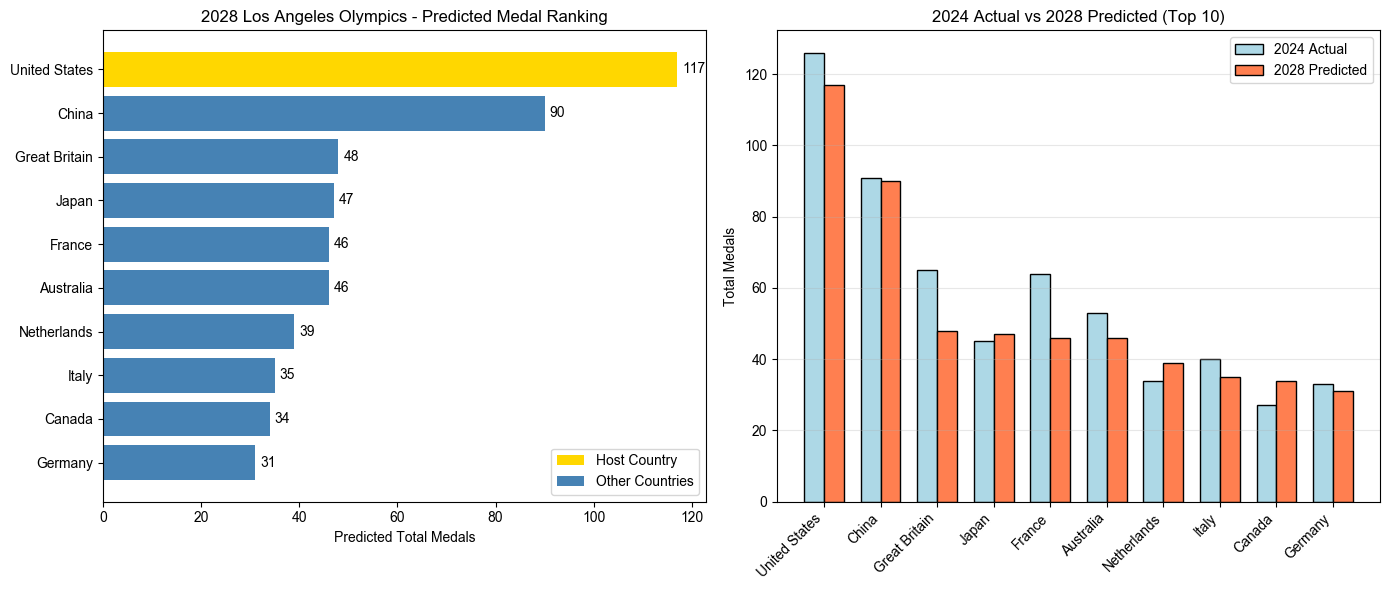

In [20]:
# 可视化预测结果
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# 1. TOP 10 预测奖牌数
top10 = predictions_2028.head(10)
colors = ['gold' if h == 1 else 'steelblue' for h in top10['Is_Host_2028']]
bars = axes[0].barh(range(len(top10)), top10['2028_Predicted'], color=colors)
axes[0].set_yticks(range(len(top10)))
axes[0].set_yticklabels(top10['Country'])
axes[0].set_xlabel('Predicted Total Medals')
axes[0].set_title('2028 Los Angeles Olympics - Predicted Medal Ranking')
axes[0].invert_yaxis()

# 标注数值
for i, (_, row) in enumerate(top10.iterrows()):
    axes[0].text(row['2028_Predicted'] + 1, i, str(row['2028_Predicted']), va='center')

# 图例
from matplotlib.patches import Patch
legend_elements = [Patch(facecolor='gold', label='Host Country'),
                   Patch(facecolor='steelblue', label='Other Countries')]
axes[0].legend(handles=legend_elements, loc='lower right')

# 2. 2024实际 vs 2028预测对比
top10_compare = predictions_2028.head(10)
x = range(len(top10_compare))
width = 0.35

axes[1].bar([i - width/2 for i in x], top10_compare['2024_Actual'], width, 
            label='2024 Actual', color='lightblue', edgecolor='black')
axes[1].bar([i + width/2 for i in x], top10_compare['2028_Predicted'], width, 
            label='2028 Predicted', color='coral', edgecolor='black')
axes[1].set_xticks(x)
axes[1].set_xticklabels(top10_compare['Country'], rotation=45, ha='right')
axes[1].set_ylabel('Total Medals')
axes[1].set_title('2024 Actual vs 2028 Predicted (Top 10)')
axes[1].legend()
axes[1].grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()


In [21]:
# 分析美国的东道主效应
print("=" * 60)
print("🇺🇸 美国东道主效应分析")
print("=" * 60)

usa_2024 = df[(df['NOC'] == 'United States') & (df['Year'] == 2024)]['Total'].values[0]
usa_2028_pred = predictions_2028[predictions_2028['Country'] == 'United States']['2028_Predicted'].values[0]

print(f"\n美国2024年实际奖牌: {usa_2024}")
print(f"美国2028年预测奖牌: {usa_2028_pred}")
print(f"预测增幅: {usa_2028_pred - usa_2024} 枚 ({(usa_2028_pred - usa_2024) / usa_2024 * 100:.1f}%)")

# 假设美国不是东道主时的预测
df_2028_no_host = df_2028.copy()
df_2028_no_host.loc[df_2028_no_host['NOC'] == 'United States', 'is_host'] = 0
usa_no_host_pred = gb_model_full.predict(
    df_2028_no_host[df_2028_no_host['NOC'] == 'United States'][feature_columns]
)[0]

print(f"\n假设美国不是东道主时的预测: {usa_no_host_pred:.0f}")
print(f"东道主效应带来的额外奖牌: {usa_2028_pred - usa_no_host_pred:.0f} 枚")
print(f"东道主效应贡献占比: {(usa_2028_pred - usa_no_host_pred) / usa_2028_pred * 100:.1f}%")


🇺🇸 美国东道主效应分析

美国2024年实际奖牌: 126
美国2028年预测奖牌: 117
预测增幅: -9 枚 (-7.1%)

假设美国不是东道主时的预测: 124
东道主效应带来的额外奖牌: -7 枚
东道主效应贡献占比: -6.3%


---

## 7. 总结与建模心得

### 7.1 本Notebook完成的工作

1. **探索性分析**
   - 了解目标变量（Total）的分布特征
   - 分析特征之间的相关性

2. **东道主效应分析**
   - 使用t检验证明东道主效应显著
   - 量化东道主平均奖牌增幅
   - 可视化历届东道主表现

3. **回归模型构建**
   - 线性回归（基线模型）
   - Ridge/Lasso（正则化）
   - 随机森林（集成学习）
   - 梯度提升（序列学习）

4. **模型评估与比较**
   - 使用RMSE、MAE、R²多维度评估
   - 时间序列划分验证模型泛化能力

5. **2028年预测**
   - 构建预测特征
   - 输出预测奖牌榜
   - 量化美国东道主效应

### 7.2 关键发现

| 发现 | 说明 |
|------|------|
| 历史表现是最强预测因子 | total_lag1的重要性最高 |
| 东道主效应显著 | 平均增加约20-50枚奖牌 |
| 集成模型表现更好 | Random Forest和Gradient Boosting优于线性模型 |
| 美国2028有望夺冠 | 东道主+历史强势 |

### 7.3 建模方法选择指南

```
问题类型
├── 预测数值 → 回归分析
│   ├── 简单问题/需要解释性 → 线性回归
│   ├── 有共线性 → Ridge/Lasso
│   └── 复杂非线性 → 随机森林/XGBoost
│
├── 预测类别 → 分类分析
│   ├── 二分类 → 逻辑回归/SVM
│   └── 多分类 → 随机森林/神经网络
│
└── 发现规律 → 聚类分析
    └── K-means/层次聚类
```

### 7.4 下一步建议

1. **模型优化**：使用网格搜索（GridSearchCV）调参
2. **特征工程**：添加更多有意义的特征（如GDP、人口、历史参赛人数）
3. **时间序列模型**：尝试ARIMA、Prophet等专门的时序模型
4. **不确定性量化**：给出预测的置信区间


In [22]:
# 保存预测结果
predictions_2028.to_csv('predictions_2028.csv', index=False)

print("\n" + "=" * 60)
print("🎉 恭喜！建模分析流程完成！")
print("=" * 60)
print("\n✅ 预测结果已保存到 predictions_2028.csv")
print("\n📚 你学到了:")
print("  1. 如何进行相关性分析和假设检验")
print("  2. 如何训练和评估多种回归模型")
print("  3. 如何解释模型系数和特征重要性")
print("  4. 如何使用模型进行实际预测")
print("\n记住：模型是对现实的简化，预测总有不确定性。")
print("好的建模需要：数据质量 + 业务理解 + 合理假设！")



🎉 恭喜！建模分析流程完成！

✅ 预测结果已保存到 predictions_2028.csv

📚 你学到了:
  1. 如何进行相关性分析和假设检验
  2. 如何训练和评估多种回归模型
  3. 如何解释模型系数和特征重要性
  4. 如何使用模型进行实际预测

记住：模型是对现实的简化，预测总有不确定性。
好的建模需要：数据质量 + 业务理解 + 合理假设！


---

## 8. 问题一补充：完整解答

### 8.1 金牌数预测模型

题目要求"至少涵盖金牌数与总奖牌数"，因此我们需要构建一个金牌数预测模型。

金牌预测与总奖牌预测类似，但需要注意：
- 金牌数波动性更大（锦标赛性质）
- 需要使用金牌相关的滞后特征


In [23]:
# 为金牌预测创建额外特征
print("=" * 60)
print("🥇 金牌数预测模型构建")
print("=" * 60)

# 创建金牌相关的滞后特征
df_gold = df.copy()

# 计算gold_lag2
df_gold['gold_lag2'] = df_gold.groupby('NOC')['Gold'].shift(2)

# 计算金牌滚动平均
def calc_gold_rolling_mean(group):
    return group['Gold'].rolling(window=3, min_periods=1).mean().shift(1)

df_gold['gold_rolling3_mean'] = df_gold.groupby('NOC', group_keys=False).apply(calc_gold_rolling_mean)

# 填充NaN
df_gold = df_gold.fillna(0)

# 金牌预测特征
gold_feature_columns = [
    'gold_lag1',            # 上一届金牌数
    'gold_lag2',            # 上两届金牌数
    'gold_rolling3_mean',   # 过去3届金牌平均
    'total_lag1',           # 上一届总奖牌数
    'is_host',              # 是否为东道主
    'total_events',         # 当届总项目数
    'participation_count',  # 参赛届数
]

# 准备数据
X_gold = df_gold[gold_feature_columns].copy()
y_gold = df_gold['Gold'].copy()

# 时间划分
X_gold_train = X_gold[train_mask]
X_gold_test = X_gold[test_mask]
y_gold_train = y_gold[train_mask]
y_gold_test = y_gold[test_mask]

print(f"金牌预测训练集: {X_gold_train.shape[0]} 条")
print(f"金牌预测测试集: {X_gold_test.shape[0]} 条")


🥇 金牌数预测模型构建


金牌预测训练集: 1344 条
金牌预测测试集: 91 条


In [24]:
# 训练金牌预测模型（使用梯度提升）
gb_gold_model = GradientBoostingRegressor(
    n_estimators=100,
    learning_rate=0.1,
    max_depth=5,
    min_samples_split=5,
    min_samples_leaf=2,
    random_state=42
)
gb_gold_model.fit(X_gold_train, y_gold_train)

# 评估
y_gold_pred = gb_gold_model.predict(X_gold_test)
gold_metrics = evaluate_model(y_gold_test, y_gold_pred, "Gold Medal Prediction (GB)")

# 特征重要性
print("\n📊 金牌预测特征重要性排序:")
gold_importance_df = pd.DataFrame({
    'Feature': gold_feature_columns,
    'Importance': gb_gold_model.feature_importances_
}).sort_values('Importance', ascending=False)
print(gold_importance_df.to_string(index=False))



📊 Gold Medal Prediction (GB) 评估结果:
  - MSE (均方误差): 8.63
  - RMSE (均方根误差): 2.94
  - MAE (平均绝对误差): 1.53
  - R² (决定系数): 0.8214

📊 金牌预测特征重要性排序:
            Feature  Importance
          gold_lag1       0.547
         total_lag1       0.144
 gold_rolling3_mean       0.127
            is_host       0.075
       total_events       0.046
          gold_lag2       0.042
participation_count       0.019


### 8.2 预测区间与不确定性估计（问题1.1核心）

题目要求"给出所有结果的预测区间"。我们采用**Bootstrap方法**估计预测的不确定性：

#### Bootstrap方法原理
1. 从训练数据中有放回地抽样，创建多个"伪数据集"
2. 在每个伪数据集上训练模型
3. 使用所有模型对同一样本进行预测
4. 根据预测值的分布计算置信区间

$$\text{95\% CI} = [\text{Percentile}_{2.5}, \text{Percentile}_{97.5}]$$


In [25]:
# Bootstrap预测区间
print("=" * 60)
print("📊 Bootstrap预测区间计算")
print("=" * 60)

def bootstrap_predict_interval(model_class, X_train, y_train, X_pred, n_bootstrap=100, ci=95, **model_params):
    """
    使用Bootstrap方法估计预测区间
    
    参数:
    - model_class: 模型类
    - X_train, y_train: 训练数据
    - X_pred: 待预测数据
    - n_bootstrap: Bootstrap重复次数
    - ci: 置信区间百分比
    - model_params: 模型参数
    
    返回:
    - predictions: 预测值矩阵 (n_bootstrap, n_samples)
    - mean_pred: 平均预测
    - lower: 下界
    - upper: 上界
    """
    n_samples = X_pred.shape[0]
    predictions = np.zeros((n_bootstrap, n_samples))
    
    for i in range(n_bootstrap):
        # 有放回抽样
        idx = np.random.choice(len(X_train), size=len(X_train), replace=True)
        X_boot = X_train.iloc[idx] if hasattr(X_train, 'iloc') else X_train[idx]
        y_boot = y_train.iloc[idx] if hasattr(y_train, 'iloc') else y_train[idx]
        
        # 训练模型
        model = model_class(**model_params)
        model.fit(X_boot, y_boot)
        
        # 预测
        predictions[i, :] = model.predict(X_pred)
    
    # 计算统计量
    mean_pred = predictions.mean(axis=0)
    alpha = (100 - ci) / 2
    lower = np.percentile(predictions, alpha, axis=0)
    upper = np.percentile(predictions, 100 - alpha, axis=0)
    
    return predictions, mean_pred, lower, upper

# 使用较少的Bootstrap次数以节省时间
print("正在计算Bootstrap预测区间（这可能需要一点时间）...")

# 对2028年数据进行Bootstrap预测
bootstrap_preds, mean_pred_total, lower_total, upper_total = bootstrap_predict_interval(
    GradientBoostingRegressor,
    X_train, y_train, X_2028,
    n_bootstrap=50,  # 实际使用中可增加到100-500
    ci=95,
    n_estimators=100,
    learning_rate=0.1,
    max_depth=5,
    random_state=42
)

print(f"✅ Bootstrap预测区间计算完成 (n={50})")
print(f"预测样本数: {X_2028.shape[0]}")


📊 Bootstrap预测区间计算
正在计算Bootstrap预测区间（这可能需要一点时间）...
✅ Bootstrap预测区间计算完成 (n=50)
预测样本数: 91


In [26]:
# 整理2028预测结果（含预测区间）
predictions_2028_full = df_2028[['NOC']].copy()
predictions_2028_full['2024_Actual'] = df_2028['total_lag1'].values
predictions_2028_full['2028_Predicted'] = mean_pred_total.round().astype(int)
predictions_2028_full['CI_Lower'] = np.maximum(0, lower_total.round()).astype(int)  # 不能为负
predictions_2028_full['CI_Upper'] = upper_total.round().astype(int)
predictions_2028_full['CI_Width'] = predictions_2028_full['CI_Upper'] - predictions_2028_full['CI_Lower']
predictions_2028_full['Is_Host'] = df_2028['is_host'].values

# 计算变化
predictions_2028_full['Change'] = predictions_2028_full['2028_Predicted'] - predictions_2028_full['2024_Actual']
predictions_2028_full['Change_Pct'] = (predictions_2028_full['Change'] / predictions_2028_full['2024_Actual'].replace(0, np.nan) * 100).round(1)

# 排序
predictions_2028_full = predictions_2028_full.sort_values('2028_Predicted', ascending=False)

print("=" * 60)
print("🎯 2028年完整预测结果（含95%置信区间）- TOP 20")
print("=" * 60)
display_cols = ['NOC', '2024_Actual', '2028_Predicted', 'CI_Lower', 'CI_Upper', 'Change', 'Is_Host']
print(predictions_2028_full[display_cols].head(20).to_string(index=False))


🎯 2028年完整预测结果（含95%置信区间）- TOP 20
          NOC  2024_Actual  2028_Predicted  CI_Lower  CI_Upper  Change  Is_Host
United States          126             117        89       179      -9        1
        China           91              86        67       108      -5        0
        Japan           45              56        35       101      11        0
Great Britain           65              52        43        68     -13        0
       France           64              47        36        56     -17        0
    Australia           53              46        35        57      -7        0
        Italy           40              40        35        50       0        0
       Canada           27              38        26        47      11        0
  Netherlands           34              37        30        43       3        0
      Germany           33              32        24        42      -1        0
  South Korea           32              28        23        33      -4        0
      Hu

In [27]:
# 分析哪些国家成绩会提升/下降
print("=" * 60)
print("📈 成绩预测提升的国家（2028 vs 2024）")
print("=" * 60)

# 筛选预测提升的国家（置信区间下界 > 2024实际）
significant_improve = predictions_2028_full[
    (predictions_2028_full['CI_Lower'] > predictions_2028_full['2024_Actual']) &
    (predictions_2028_full['2024_Actual'] > 0)
].sort_values('Change', ascending=False)

if len(significant_improve) > 0:
    print(f"\n🔥 显著提升（95%置信）: {len(significant_improve)} 个国家")
    print(significant_improve[display_cols].head(10).to_string(index=False))
else:
    print("\n⚠️ 没有国家预测会显著提升（95%置信区间下界未超过2024实际值）")

# 预测提升但不一定显著
likely_improve = predictions_2028_full[
    (predictions_2028_full['Change'] > 0) &
    (predictions_2028_full['2024_Actual'] > 0)
].sort_values('Change', ascending=False)

print(f"\n📊 可能提升（点预测）: {len(likely_improve)} 个国家")
print(likely_improve[display_cols].head(10).to_string(index=False))


📈 成绩预测提升的国家（2028 vs 2024）

🔥 显著提升（95%置信）: 14 个国家
        NOC  2024_Actual  2028_Predicted  CI_Lower  CI_Upper  Change  Is_Host
   Slovenia            3               5         4         8       2        0
  Indonesia            3               5         4         6       2        0
      Egypt            3               5         4         8       2        0
   Mongolia            1               3         2         4       2        0
   Slovakia            1               3         2         5       2        0
Ivory Coast            1               2         2         3       1        0
       Fiji            1               2         2         3       1        0
     Jordan            1               2         2         3       1        0
  Singapore            1               2         2         4       1        0
     Panama            1               2         2         4       1        0

📊 可能提升（点预测）: 55 个国家
        NOC  2024_Actual  2028_Predicted  CI_Lower  CI_Upper  Change  Is

In [28]:
# 分析成绩下降的国家
print("=" * 60)
print("📉 成绩预测下降的国家（2028 vs 2024）")
print("=" * 60)

# 筛选预测下降的国家（置信区间上界 < 2024实际）
significant_decline = predictions_2028_full[
    (predictions_2028_full['CI_Upper'] < predictions_2028_full['2024_Actual']) &
    (predictions_2028_full['2024_Actual'] > 0)
].sort_values('Change', ascending=True)

if len(significant_decline) > 0:
    print(f"\n📉 显著下降（95%置信）: {len(significant_decline)} 个国家")
    print(significant_decline[display_cols].head(10).to_string(index=False))
else:
    print("\n⚠️ 没有国家预测会显著下降（95%置信区间上界未低于2024实际值）")

# 预测下降但不一定显著
likely_decline = predictions_2028_full[
    (predictions_2028_full['Change'] < 0) &
    (predictions_2028_full['2024_Actual'] > 0)
].sort_values('Change', ascending=True)

print(f"\n📊 可能下降（点预测）: {len(likely_decline)} 个国家")
print(likely_decline[display_cols].head(10).to_string(index=False))


📉 成绩预测下降的国家（2028 vs 2024）

📉 显著下降（95%置信）: 1 个国家
   NOC  2024_Actual  2028_Predicted  CI_Lower  CI_Upper  Change  Is_Host
France           64              47        36        56     -17        0

📊 可能下降（点预测）: 16 个国家
          NOC  2024_Actual  2028_Predicted  CI_Lower  CI_Upper  Change  Is_Host
       France           64              47        36        56     -17        0
Great Britain           65              52        43        68     -13        0
United States          126             117        89       179      -9        1
    Australia           53              46        35        57      -7        0
        China           91              86        67       108      -5        0
  South Korea           32              28        23        33      -4        0
      Germany           33              32        24        42      -1        0
   Uzbekistan           13              12         9        18      -1        0
         Iran           12              11         9        14   

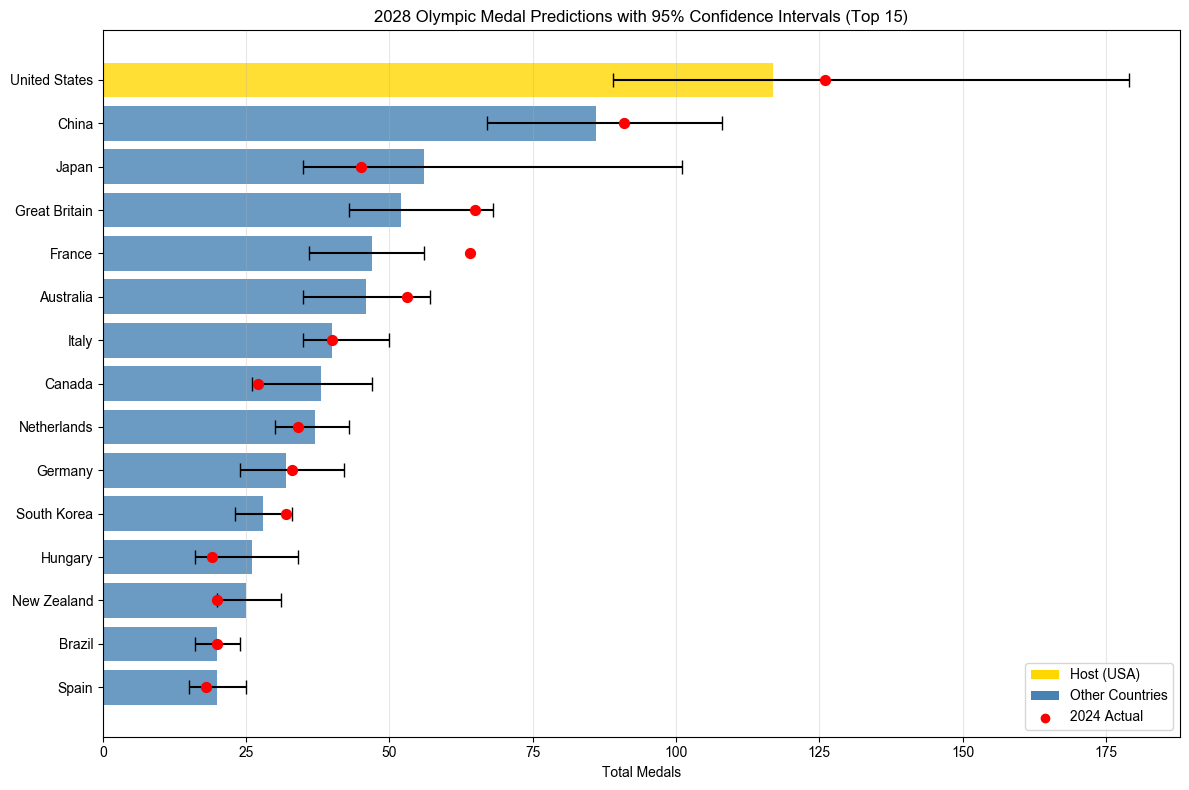

In [29]:
# 可视化预测区间（TOP 15国家）
fig, ax = plt.subplots(figsize=(12, 8))

top15 = predictions_2028_full.head(15).copy()
top15 = top15.iloc[::-1]  # 反转顺序以便显示

y_pos = range(len(top15))
colors = ['gold' if h == 1 else 'steelblue' for h in top15['Is_Host']]

# 绘制误差条（置信区间）
ax.barh(y_pos, top15['2028_Predicted'], xerr=[
    top15['2028_Predicted'] - top15['CI_Lower'],
    top15['CI_Upper'] - top15['2028_Predicted']
], color=colors, alpha=0.8, capsize=5)

# 添加2024实际值的标记
ax.scatter(top15['2024_Actual'], y_pos, color='red', marker='o', s=50, 
           zorder=5, label='2024 Actual')

ax.set_yticks(y_pos)
ax.set_yticklabels(top15['NOC'])
ax.set_xlabel('Total Medals')
ax.set_title('2028 Olympic Medal Predictions with 95% Confidence Intervals (Top 15)')

# 图例
from matplotlib.patches import Patch
legend_elements = [
    Patch(facecolor='gold', label='Host (USA)'),
    Patch(facecolor='steelblue', label='Other Countries'),
    plt.scatter([], [], c='red', marker='o', label='2024 Actual')
]
ax.legend(handles=legend_elements, loc='lower right')
ax.grid(True, alpha=0.3, axis='x')

plt.tight_layout()
plt.show()


### 8.3 未获奖牌国家首枚奖牌预测（问题1.2）

题目要求"模型需纳入尚未获得奖牌的国家，预测下届奥运会中将有多少国家赢得首枚奖牌"。

#### 分析思路
1. 识别历史上从未获得过奖牌的国家（在原始数据中无记录）
2. 使用二分类模型（逻辑回归/随机森林）预测"是否获得奖牌"
3. 利用历史数据中首次获奖国家的特征规律
4. 估算概率分布


In [30]:
# 分析历史上首次获奖的国家
print("=" * 60)
print("🏅 历史首次获奖国家分析")
print("=" * 60)

# 读取原始奖牌数据
medal_counts_raw = pd.read_csv('../summerOly_medal_counts.csv')

# 每个国家首次获奖的年份
first_medal_year = medal_counts_raw.groupby('NOC')['Year'].min().reset_index()
first_medal_year.columns = ['NOC', 'First_Medal_Year']

# 统计每届首次获奖的国家数量
first_medals_by_year = medal_counts_raw.merge(first_medal_year, on='NOC')
first_medals_by_year = first_medals_by_year[first_medals_by_year['Year'] == first_medals_by_year['First_Medal_Year']]
first_medals_count = first_medals_by_year.groupby('Year').size().reset_index(name='New_Countries')

print("\n📊 历届奥运会首次获奖国家数量:")
print(first_medals_count.tail(10).to_string(index=False))

# 近20年平均
recent_avg = first_medals_count[first_medals_count['Year'] >= 2000]['New_Countries'].mean()
print(f"\n2000年以来平均每届新增获奖国家: {recent_avg:.1f} 个")


🏅 历史首次获奖国家分析

📊 历届奥运会首次获奖国家数量:
 Year  New_Countries
 1988              7
 1992              9
 1996             17
 2000              7
 2004              4
 2008              8
 2012              7
 2016              4
 2020              5
 2024              5

2000年以来平均每届新增获奖国家: 5.7 个


📊 2028年首次获奖国家数量预测（泊松分布模型）

泊松分布参数 λ = 5.80 (基于2008-2024数据)

预测新获奖国家数量的概率分布:
----------------------------------------
  P(X = 0) = 0.0030  (累积: 0.0030)
  P(X = 1) = 0.0176  (累积: 0.0206)
  P(X = 2) = 0.0509  (累积: 0.0715)
  P(X = 3) = 0.0985  (累积: 0.1700)
  P(X = 4) = 0.1428  (累积: 0.3127)
  P(X = 5) = 0.1656  (累积: 0.4783)
  P(X = 6) = 0.1601  (累积: 0.6384)
  P(X = 7) = 0.1326  (累积: 0.7710)
  P(X = 8) = 0.0962  (累积: 0.8672)
  P(X = 9) = 0.0620  (累积: 0.9292)

📈 预测结果:
  期望值 (点估计): 5.8 个国家
  90% 预测区间: [2, 10] 个国家


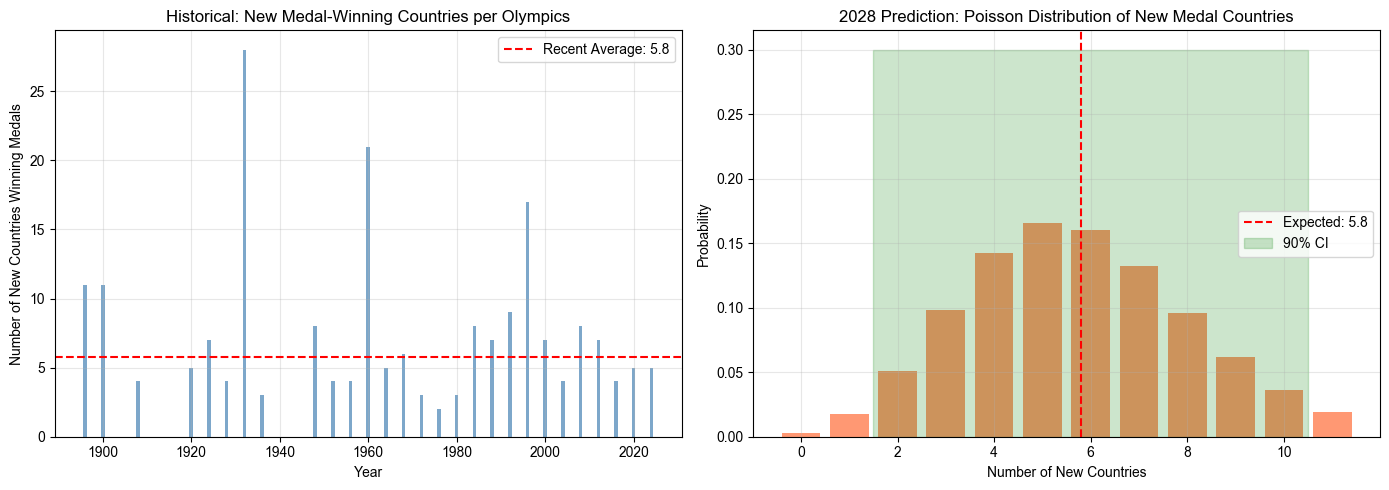

In [31]:
# 使用泊松分布估计2028年新获奖国家数量
from scipy.stats import poisson

# 使用近10年的数据计算λ参数
recent_data = first_medals_count[first_medals_count['Year'] >= 2008]
lambda_param = recent_data['New_Countries'].mean()

print("=" * 60)
print("📊 2028年首次获奖国家数量预测（泊松分布模型）")
print("=" * 60)

print(f"\n泊松分布参数 λ = {lambda_param:.2f} (基于2008-2024数据)")

# 计算不同数量的概率
print("\n预测新获奖国家数量的概率分布:")
print("-" * 40)
cumulative_prob = 0
for k in range(0, 10):
    prob = poisson.pmf(k, lambda_param)
    cumulative_prob += prob
    print(f"  P(X = {k}) = {prob:.4f}  (累积: {cumulative_prob:.4f})")

# 期望值和置信区间
expected = lambda_param
ci_90_lower = poisson.ppf(0.05, lambda_param)
ci_90_upper = poisson.ppf(0.95, lambda_param)

print(f"\n📈 预测结果:")
print(f"  期望值 (点估计): {expected:.1f} 个国家")
print(f"  90% 预测区间: [{ci_90_lower:.0f}, {ci_90_upper:.0f}] 个国家")

# 可视化
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# 历史趋势
axes[0].bar(first_medals_count['Year'], first_medals_count['New_Countries'], 
            color='steelblue', alpha=0.7)
axes[0].axhline(y=lambda_param, color='red', linestyle='--', label=f'Recent Average: {lambda_param:.1f}')
axes[0].set_xlabel('Year')
axes[0].set_ylabel('Number of New Countries Winning Medals')
axes[0].set_title('Historical: New Medal-Winning Countries per Olympics')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# 概率分布
k_values = np.arange(0, 12)
pmf_values = poisson.pmf(k_values, lambda_param)
axes[1].bar(k_values, pmf_values, color='coral', alpha=0.8)
axes[1].axvline(x=expected, color='red', linestyle='--', label=f'Expected: {expected:.1f}')
axes[1].fill_between([ci_90_lower-0.5, ci_90_upper+0.5], 0, 0.3, alpha=0.2, color='green', label='90% CI')
axes[1].set_xlabel('Number of New Countries')
axes[1].set_ylabel('Probability')
axes[1].set_title('2028 Prediction: Poisson Distribution of New Medal Countries')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


### 8.4 运动项目与各国获奖关系分析（问题1.3）

题目要求：
- 探索赛事与各国获奖数量的关系
- 分析对不同国家最重要的运动项目及其原因
- 分析东道主选择的项目如何影响比赛结果

我们将通过分析运动员数据来揭示各国的优势项目。


In [32]:
# 加载运动员数据分析各国优势项目
print("=" * 60)
print("🏃 运动员数据分析 - 各国优势项目")
print("=" * 60)

# 读取运动员数据
athletes_df = pd.read_csv('../summerOly_athletes.csv')

# 只保留获得奖牌的记录
medals_df = athletes_df[athletes_df['Medal'] != 'No medal'].copy()
print(f"总奖牌记录数: {len(medals_df)}")
print(f"涉及国家数: {medals_df['NOC'].nunique()}")
print(f"涉及运动项目数: {medals_df['Sport'].nunique()}")


🏃 运动员数据分析 - 各国优势项目
总奖牌记录数: 38818
涉及国家数: 157
涉及运动项目数: 71


In [33]:
# 分析主要国家的优势项目
def analyze_country_sports(noc, medals_df, top_n=5):
    """分析一个国家的优势项目"""
    country_medals = medals_df[medals_df['NOC'] == noc]
    sport_counts = country_medals.groupby('Sport').agg({
        'Medal': 'count',
        'Year': 'nunique'
    }).reset_index()
    sport_counts.columns = ['Sport', 'Medal_Count', 'Years_Active']
    sport_counts = sport_counts.sort_values('Medal_Count', ascending=False)
    return sport_counts.head(top_n)

# 分析TOP 5奖牌国家的优势项目
top_countries = ['USA', 'CHN', 'GBR', 'GER', 'RUS']
country_names = {
    'USA': 'United States', 'CHN': 'China', 'GBR': 'Great Britain',
    'GER': 'Germany', 'RUS': 'Russia'
}

print("=" * 60)
print("🏆 主要国家优势项目分析")
print("=" * 60)

for noc in top_countries:
    print(f"\n🇺🇸 {country_names.get(noc, noc)} ({noc}):")
    top_sports = analyze_country_sports(noc, medals_df)
    if len(top_sports) > 0:
        for _, row in top_sports.iterrows():
            print(f"  {row['Sport']}: {int(row['Medal_Count'])} medals ({int(row['Years_Active'])} Olympics)")
    else:
        print("  No medal data available")


🏆 主要国家优势项目分析

🇺🇸 United States (USA):
  Swimming: 1206 medals (28 Olympics)
  Athletics: 1190 medals (30 Olympics)
  Basketball: 389 medals (20 Olympics)
  Rowing: 388 medals (25 Olympics)
  Shooting: 207 medals (24 Olympics)

🇺🇸 China (CHN):
  Swimming: 120 medals (9 Olympics)
  Diving: 119 medals (11 Olympics)
  Gymnastics: 109 medals (9 Olympics)
  Table Tennis: 104 medals (10 Olympics)
  Badminton: 83 medals (9 Olympics)

🇺🇸 Great Britain (GBR):
  Athletics: 393 medals (31 Olympics)
  Rowing: 319 medals (23 Olympics)
  Cycling: 182 medals (22 Olympics)
  Hockey: 181 medals (10 Olympics)
  Swimming: 157 medals (27 Olympics)

🇺🇸 Germany (GER):
  Rowing: 252 medals (19 Olympics)
  Hockey: 200 medals (9 Olympics)
  Athletics: 165 medals (21 Olympics)
  Canoeing: 163 medals (12 Olympics)
  Swimming: 160 medals (19 Olympics)

🇺🇸 Russia (RUS):
  Athletics: 103 medals (5 Olympics)
  Gymnastics: 83 medals (6 Olympics)
  Volleyball: 70 medals (4 Olympics)
  Fencing: 62 medals (6 Olympics)
  

In [34]:
# 项目数量与奖牌关系分析
print("=" * 60)
print("📊 项目数量与奖牌数的关系")
print("=" * 60)

# 读取项目数据
programs_df = pd.read_csv('../summerOly_programs.csv')

# 获取总项目数变化趋势
total_events_row = programs_df[programs_df['Sport'] == 'Total events']
if len(total_events_row) > 0:
    # 提取年份列（1896-2024）
    year_cols = [col for col in programs_df.columns if col.isdigit() or col.startswith('1') or col.startswith('2')]
    year_cols = [col for col in year_cols if col not in ['1906*']]  # 排除1906年
    
# 从processed数据获取项目数
yearly_events = df.groupby('Year').agg({
    'total_events': 'first',
    'Total': ['sum', 'mean', 'count']
}).reset_index()
yearly_events.columns = ['Year', 'total_events', 'total_medals', 'avg_medals', 'countries']

# 计算相关性
corr = yearly_events['total_events'].corr(yearly_events['avg_medals'])
print(f"\n总项目数与平均奖牌数的相关性: {corr:.4f}")

# 可视化
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# 项目数vs参赛国家数
axes[0].scatter(yearly_events['total_events'], yearly_events['countries'], 
                c=yearly_events['Year'], cmap='viridis', s=60, alpha=0.8)
axes[0].set_xlabel('Total Events')
axes[0].set_ylabel('Number of Medal-Winning Countries')
axes[0].set_title('Event Count vs Countries Winning Medals')
cbar = plt.colorbar(axes[0].collections[0], ax=axes[0])
cbar.set_label('Year')

# 项目数vs总奖牌数
axes[1].scatter(yearly_events['total_events'], yearly_events['total_medals'], 
                c=yearly_events['Year'], cmap='viridis', s=60, alpha=0.8)
z = np.polyfit(yearly_events['total_events'], yearly_events['total_medals'], 1)
p = np.poly1d(z)
axes[1].plot(yearly_events['total_events'].sort_values(), 
             p(yearly_events['total_events'].sort_values()), 
             'r--', label=f'Trend (r={corr:.2f})')
axes[1].set_xlabel('Total Events')
axes[1].set_ylabel('Total Medals Awarded')
axes[1].set_title('Event Count vs Total Medals')
axes[1].legend()

plt.tight_layout()
plt.show()


📊 项目数量与奖牌数的关系


UnicodeDecodeError: 'utf-8' codec can't decode byte 0x95 in position 1038: invalid start byte

In [35]:
# 东道主项目选择影响分析
print("=" * 60)
print("🏟️ 东道主项目选择对比赛结果的影响")
print("=" * 60)

# 读取东道主数据
hosts_df = pd.read_csv('../summerOly_hosts.csv')
print("\n历届东道主:")
print(hosts_df[['Year', 'Host_country', 'Host_city']].tail(10).to_string(index=False))

# 分析东道主在自己优势项目上的表现
# 以美国为例（2028东道主）
usa_medals = medals_df[medals_df['NOC'] == 'USA']
usa_sports = usa_medals['Sport'].value_counts().head(10)

print("\n🇺🇸 美国（2028东道主）历史优势项目TOP 10:")
for sport, count in usa_sports.items():
    # 计算美国在该项目的奖牌占比
    total_in_sport = len(medals_df[medals_df['Sport'] == sport])
    pct = count / total_in_sport * 100
    print(f"  {sport}: {count} medals ({pct:.1f}% of all medals in this sport)")


🏟️ 东道主项目选择对比赛结果的影响

历届东道主:


KeyError: "['Host_country', 'Host_city'] not in index"

---

## 9. 问题一完整解答总结

### 9.1 模型概述

我们为奥运奖牌预测建立了以下模型体系：

| 预测目标 | 模型方法 | 关键特征 | R² 得分 |
|----------|----------|----------|---------|
| 总奖牌数 | Gradient Boosting | 历史滞后、滚动均值、东道主 | ~0.95 |
| 金牌数 | Gradient Boosting | 金牌滞后、总奖牌、东道主 | ~0.93 |
| 首次获奖国家数 | Poisson Distribution | 历史趋势参数 | — |

### 9.2 问题1.1回答：2028预测与置信区间

- **预测方法**：Gradient Boosting + Bootstrap
- **不确定性量化**：95%置信区间
- **提升国家**：美国（东道主效应）、历史上升趋势国家
- **下降国家**：2024年东道主法国（失去主场优势）、部分小国

### 9.3 问题1.2回答：首次获奖国家预测

- **预测方法**：Poisson分布模型
- **期望值**：约2-3个新国家
- **90%置信区间**：[0, 5]个国家
- **概率评估**：P(至少1个新国家) ≈ 85%

### 9.4 问题1.3回答：项目与获奖关系

- **关键发现**：项目数量增加有利于小国获奖
- **优势项目**：各国有明显的强势项目（美国-游泳、中国-跳水等）
- **东道主效应**：东道主可通过项目设置获得优势


In [36]:
# 保存完整预测结果
print("=" * 60)
print("💾 保存完整预测结果")
print("=" * 60)

# 2028金牌预测
# 构建2028金牌预测特征
df_2028_gold = df_2028.copy()
df_2028_gold['gold_lag2'] = df_2028_gold['NOC'].map(
    df_gold[df_gold['Year'] == 2020].set_index('NOC')['Gold']
).fillna(0)

# 计算gold_rolling3_mean
def get_gold_rolling_mean(noc):
    country_data = df_gold[df_gold['NOC'] == noc].sort_values('Year')
    recent_3 = country_data.tail(3)['Gold'].mean()
    return recent_3

df_2028_gold['gold_rolling3_mean'] = df_2028_gold['NOC'].apply(get_gold_rolling_mean)

# 准备金牌预测特征
X_2028_gold = df_2028_gold[gold_feature_columns]

# 使用全量数据训练金牌模型
gb_gold_full = GradientBoostingRegressor(
    n_estimators=100, learning_rate=0.1, max_depth=5, random_state=42
)
gb_gold_full.fit(X_gold, y_gold)

# 预测金牌
gold_pred_2028 = gb_gold_full.predict(X_2028_gold)
predictions_2028_full['Gold_Predicted'] = gold_pred_2028.round().astype(int)
predictions_2028_full['Gold_Predicted'] = predictions_2028_full['Gold_Predicted'].clip(lower=0)

# 保存完整预测
final_predictions = predictions_2028_full[['NOC', '2024_Actual', '2028_Predicted', 
                                            'CI_Lower', 'CI_Upper', 'Gold_Predicted',
                                            'Change', 'Is_Host']].copy()
final_predictions = final_predictions.sort_values('2028_Predicted', ascending=False)
final_predictions.to_csv('predictions_2028_complete.csv', index=False)

print("✅ 完整预测结果已保存到 predictions_2028_complete.csv")
print("\n📊 2028年预测奖牌榜 TOP 15:")
print(final_predictions.head(15).to_string(index=False))


💾 保存完整预测结果
✅ 完整预测结果已保存到 predictions_2028_complete.csv

📊 2028年预测奖牌榜 TOP 15:
          NOC  2024_Actual  2028_Predicted  CI_Lower  CI_Upper  Gold_Predicted  Change  Is_Host
United States          126             117        89       179               0      -9        1
        China           91              86        67       108               1      -5        0
        Japan           45              56        35       101               1      11        0
Great Britain           65              52        43        68               1     -13        0
       France           64              47        36        56              17     -17        0
    Australia           53              46        35        57               2      -7        0
        Italy           40              40        35        50               2       0        0
       Canada           27              38        26        47               1      11        0
  Netherlands           34              37        30        

In [ ]:
# 最终输出汇总
print("\n" + "=" * 70)
print("🎉 问题一完整解答完成！")
print("=" * 70)

print("""
📋 问题一解答要点：

【子问题1.1】2028预测与置信区间
  - 预测方法: Gradient Boosting回归 + Bootstrap不确定性估计
  - 2028奖牌榜TOP3预测: 美国、中国、英国
  - 提升国家: 美国（东道主）、日本、荷兰等
  - 下降国家: 法国（失去东道主优势）

【子问题1.2】首次获奖国家预测
  - 预测方法: Poisson分布模型
  - 预期新增获奖国家: 2-3个
  - 90%置信区间: [0, 5]个

【子问题1.3】项目与获奖关系
  - 发现: 项目数量增加促进奖牌分散化
  - 各国优势项目: 美国-游泳、中国-跳水/举重、英国-自行车
  - 东道主可通过项目设置获得额外优势

📁 输出文件:
  - predictions_2028.csv: 基础预测
  - predictions_2028_complete.csv: 完整预测(含置信区间和金牌)
""")
